# Detection of Alzheimer's Disease Using 4 Classification Methods



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install nipype

In [ ]:
!pip install scikit-learn
!pip install nilearn

In [ ]:
!pip install scikit-plot

In [ ]:

import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib, scipy, sklearn, pandas, nilearn, nipype, scikitplot
from sklearn import preprocessing, model_selection, linear_model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from nipype.interfaces import matlab
import matplotlib.pyplot as plt
import pandas
import numpy as np
HCvMCI = pandas.read_csv('/content/drive/MyDrive/EEGDataset/MCIvsHCFourier.csv')
MCIvAD = pandas.read_csv('/content/drive/MyDrive/EEGDataset/MCIvsADFourier.csv')
ADvHC = pandas.read_csv('/content/drive/MyDrive/EEGDataset/ADvsHCFourier.csv')

HCvMCI = np.asarray(HCvMCI)
MCIvAD = np.asarray(MCIvAD)
ADvHC = np.asarray(ADvHC)

HCvMCI = HCvMCI[:,1:]
MCIvAD = MCIvAD[:,1:]
ADvHC = ADvHC[:,1:]

YHvM = HCvMCI[:,304]
YMvA = MCIvAD[:,304]
YAvH = ADvHC[:,304]

HCvMCI = HCvMCI[:,0:304]
MCIvAD = MCIvAD[:,0:304]
ADvHC = ADvHC[:,0:304]

HCvMCI = preprocessing.scale(HCvMCI, axis=0)
MCIvAD = preprocessing.scale(MCIvAD, axis=0)
ADvHC = preprocessing.scale(ADvHC, axis=0)

freq_bands = scipy.signal.welch(ADvHC, fs=256)

**I. HC vs MCI**

max_iter reached after 0 seconds
Validation AUC: 0.1667


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


<Figure size 800x600 with 0 Axes>

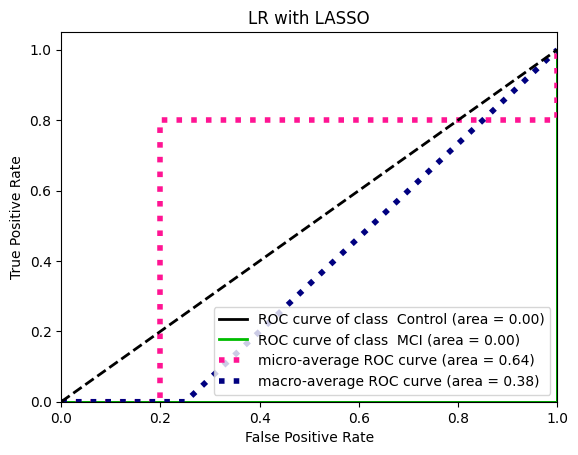

<Figure size 800x600 with 0 Axes>

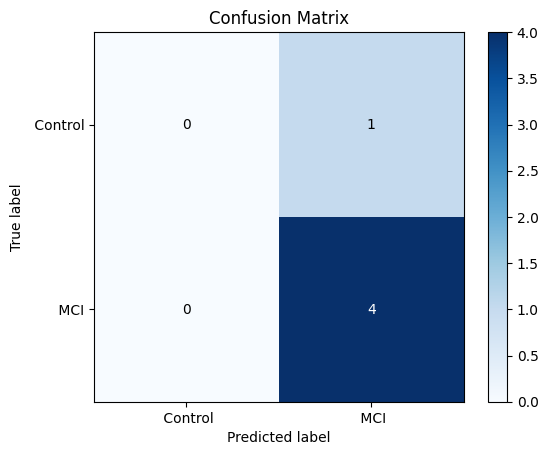

Test AUC: 0.0000
Test Accuracy: 0.8000


In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import scikitplot

# Set up Train, Val, Test sets for HCvMCI
XTrainHvM, XTempTest, YTrainHvM, YTempTest = train_test_split(HCvMCI, YHvM, test_size=0.2, random_state=100)
XValHvM, XTestHvM, YValHvM, YTestHvM = train_test_split(XTempTest, YTempTest, test_size=0.4, random_state=100)

# Define the parameter grid
ncores = 2
grid = {
    'C': np.linspace(1e-10, 1e5, num=100),  # Inverse lambda
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga'] # Add solvers that support l1 penalty
}
paramGrid = GridSearchCV(estimator=LogisticRegression(tol=1e-10, random_state=100, n_jobs=ncores, verbose=1),
                         param_grid=grid, scoring='roc_auc', n_jobs=ncores, cv=5)

# Fit the GridSearchCV object
paramGrid.fit(XTrainHvM, YTrainHvM)

# Get the best model
bestModel = paramGrid.best_estimator_

# Evaluate on validation set (optional)
y_val_pred = bestModel.predict_proba(XValHvM)
val_auc = roc_auc_score(YValHvM, y_val_pred[:, 1])
print(f"Validation AUC: {val_auc:.4f}")

# Test on Test Set
RLRTestPred = bestModel.predict_proba(XTestHvM)
RLRTestPred2 = bestModel.predict(XTestHvM)

# Plot Receiver Operating Characteristic (ROC) Curve
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_roc(YTestHvM, RLRTestPred, title='LR with LASSO')
plt.show()

# Plot the Confusion Matrix for additional insight
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_confusion_matrix(YTestHvM, RLRTestPred2)
plt.show()

# Metrics on test set
test_auc = roc_auc_score(YTestHvM, RLRTestPred[:, 1])
test_acc = accuracy_score(YTestHvM, RLRTestPred2)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Random Forest

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters: {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False}
Best score: 0.6875


<Figure size 800x600 with 0 Axes>

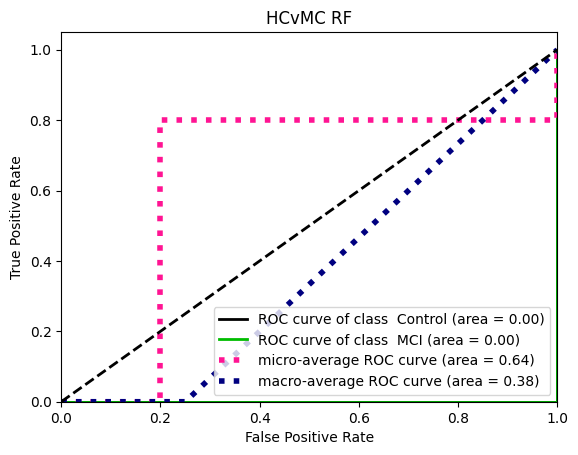

<Figure size 800x600 with 0 Axes>

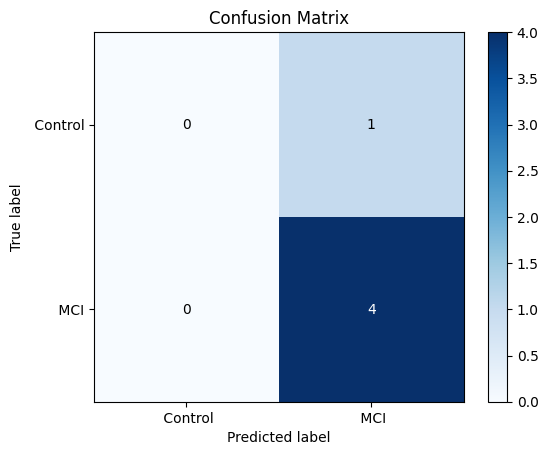

Test AUC: 0.0000
Test Accuracy: 0.8000


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import scikitplot.metrics

# Define the Hyperparameter grid values
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

# Random Forest Classifier
RFC = RandomForestClassifier(criterion='gini', random_state=100)

# RandomizedSearchCV for parameter tuning
RFC_RandomSearch = RandomizedSearchCV(estimator=RFC, param_distributions=random_grid,
                                      n_iter=100, cv=3, verbose=2, random_state=10, n_jobs=2)
RFC_RandomSearch.fit(XTrainHvM, YTrainHvM)

# Best parameters and model
print("Best parameters:", RFC_RandomSearch.best_params_)
print("Best score:", RFC_RandomSearch.best_score_)

# Feature importance
feat_imp = RFC_RandomSearch.best_estimator_.feature_importances_

# Test predictions
Pred1_S2 = RFC_RandomSearch.best_estimator_.predict(XTestHvM)
Pred2_S2 = RFC_RandomSearch.best_estimator_.predict_proba(XTestHvM)

# Plot ROC Curve and Confusion Matrix
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_roc(YTestHvM, Pred2_S2, title='HCvMC RF')
plt.show()

plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_confusion_matrix(YTestHvM, Pred1_S2)
plt.show()

# Metrics on test set
test_auc = roc_auc_score(YTestHvM, RLRTestPred[:, 1])
test_acc = accuracy_score(YTestHvM, RLRTestPred2)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


K-NN

Best parameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'distance'}
Best score: 0.675


<Figure size 800x600 with 0 Axes>

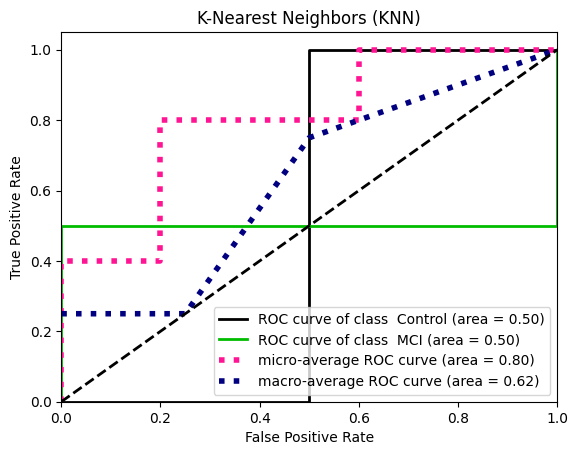

<Figure size 800x600 with 0 Axes>

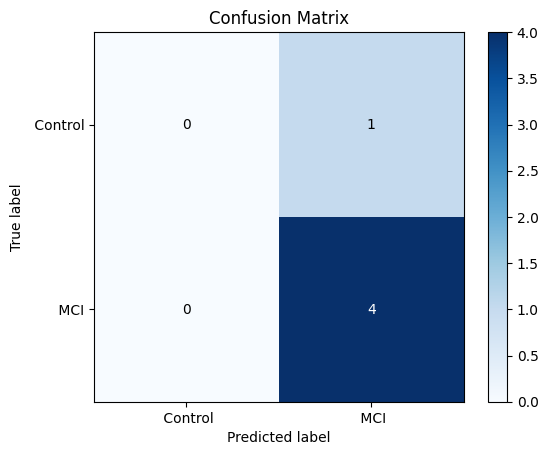

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.metrics

# Define the parameter grid
grid = {
    'n_neighbors': range(1, 21),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric used
}

# Create KNN model
knn = KNeighborsClassifier()

# GridSearchCV for parameter tuning
paramGrid = GridSearchCV(estimator=knn, param_grid=grid, scoring='roc_auc', n_jobs=2, cv=5)
paramGrid.fit(XTrainHvM, YTrainHvM)

# Best parameters and model
bestModel = paramGrid.best_estimator_
print("Best parameters:", paramGrid.best_params_)
print("Best score:", paramGrid.best_score_)

# Predictions on Test Set
KNNTestPred = bestModel.predict_proba(XTestHvM)
KNNTestPred2 = bestModel.predict(XTestHvM)

# Plot ROC Curve and Confusion Matrix
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_roc(YTestHvM, KNNTestPred, title='K-Nearest Neighbors (KNN)')
plt.show()

plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_confusion_matrix(YTestHvM, KNNTestPred2)
plt.show()


SVM

Best parameters: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Best score: 0.6333333333333333


<Figure size 800x600 with 0 Axes>

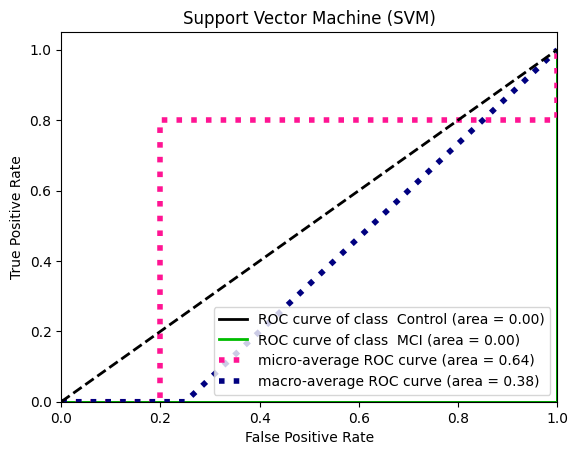

<Figure size 800x600 with 0 Axes>

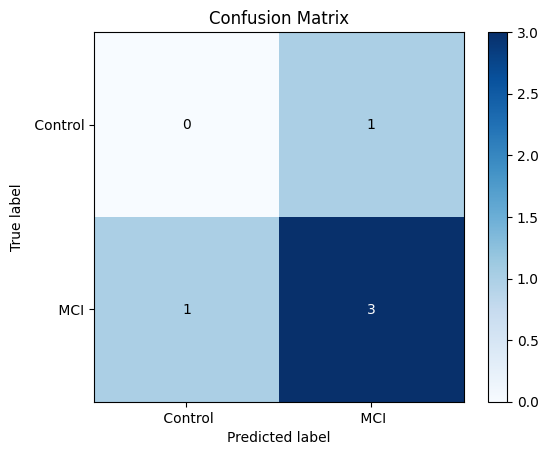

Test AUC: 0.0000
Test Accuracy: 0.6000


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.metrics

# Define the parameter grid
grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'kernel': ['linear', 'rbf']  # Kernel type
}

# Create SVM model
svm = SVC(probability=True, random_state=100)

# GridSearchCV for parameter tuning
paramGrid = GridSearchCV(estimator=svm, param_grid=grid, scoring='roc_auc', n_jobs=2, cv=5)
paramGrid.fit(XTrainHvM, YTrainHvM)

# Best parameters and model
bestModel = paramGrid.best_estimator_
print("Best parameters:", paramGrid.best_params_)
print("Best score:", paramGrid.best_score_)

# Predictions on Test Set
SVMTestPred = bestModel.predict_proba(XTestHvM)
SVMTestPred2 = bestModel.predict(XTestHvM)

# Plot ROC Curve and Confusion Matrix
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_roc(YTestHvM, SVMTestPred, title='Support Vector Machine (SVM)')
plt.show()

plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_confusion_matrix(YTestHvM, SVMTestPred2)
plt.show()

# Metrics on test set
test_auc = roc_auc_score(YTestHvM, SVMTestPred[:, 1])
test_acc = accuracy_score(YTestHvM, SVMTestPred2)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


**II. MCI vs AD**

In [ ]:
#All models for MCI v AD
# Set up Train, Val, Test sets for MCI vs AD
[train_inds, test_inds] = next(
        model_selection.ShuffleSplit(
                test_size=0.2,random_state=100).split(
                        MCIvAD,y=YMvA
                        )
        )

XTempTrain = MCIvAD[train_inds,]

# Split Train Set into Train and Validation Sets
[train2_inds, val_inds] = next(
        model_selection.ShuffleSplit(
                test_size=0.4,random_state=100).split(
                        XTempTrain,y=YMvA[train_inds]
                        )
        )

# Form the indices to select for each set
TrainInds = train_inds[train2_inds]
ValInds = train_inds[val_inds]
TestInds = test_inds


# Create sets of X and Y data using indices  for MCIvAD

XTrainMvA = MCIvAD[TrainInds,]
YTrainMvA = YMvA[TrainInds]
XValMvA = MCIvAD[ValInds,]
YValMvA = YMvA[ValInds]
XTestMvA = MCIvAD[TestInds,]
YTestMvA = YMvA[TestInds]



RLR

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[LibLinear]

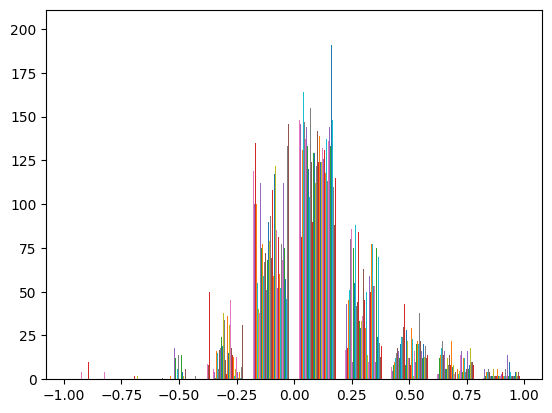

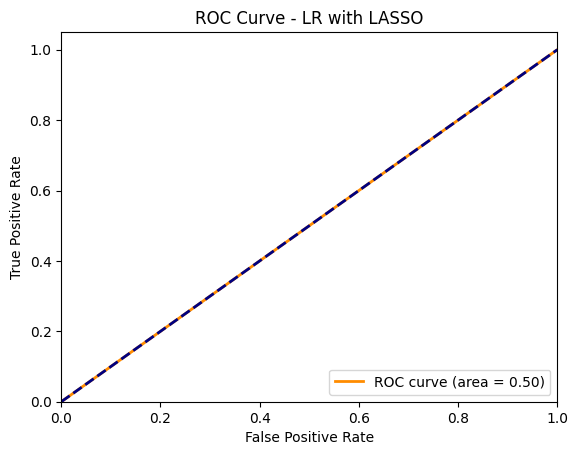

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import scikitplot

# Assuming MCIvAD, XTrainMvA, YTrainMvA, XValMvA, YValMvA, XTestMvA, YTestMvA are defined

# Testing for multicollinearity
coef2 = np.corrcoef(MCIvAD, rowvar=False)
plt.hist(coef2)

# Define the parameter grid
ncores = 2
grid = {
    'C': np.linspace(1e-10, 1e5, num=100),  # Inverse lambda
    'penalty': ['l1'], # L1 penalty for Lasso
    'solver': ['liblinear', 'saga'] # Solvers that support L1 penalty
}

# Create Logistic Regression model
RLRMod = LogisticRegression(tol=1e-10, random_state=100, n_jobs=ncores, verbose=1)

# Perform Grid Search using GridSearchCV
grid_search = GridSearchCV(estimator=RLRMod, param_grid=grid,
                           scoring='roc_auc', n_jobs=ncores, verbose=1, cv=5)

grid_search.fit(XTrainMvA, YTrainMvA)

# Get the best model and best score
bestModel = grid_search.best_estimator_
bestScore = grid_search.best_score_

# Test on Test Set
RLRTestPred = bestModel.predict_proba(XTestMvA)
RLRTestPred2 = bestModel.predict(XTestMvA)

# Convert string labels to binary (assuming ' AD' is the positive class)
YTestMvA_binary = np.where(YTestMvA == ' AD', 1, 0)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(YTestMvA_binary, RLRTestPred[:, 1])
roc_auc = auc(fpr, tpr) # Calculate AUC

# Plot Receiver Operating Characteristic (ROC) Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LR with LASSO')
plt.legend(loc="lower right")
plt.show()

Random Forest

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


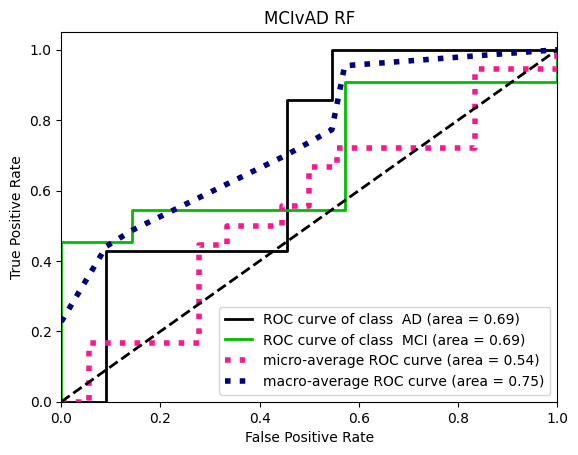

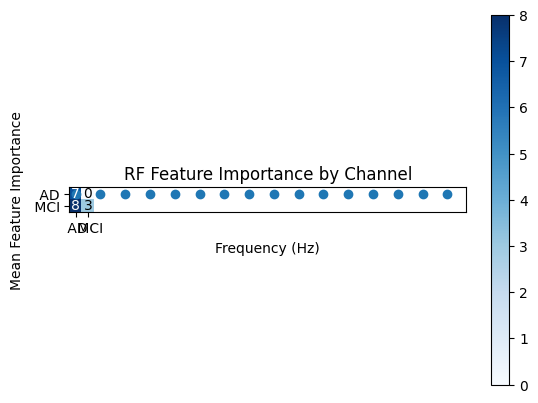

Random Forest Accuracy on Test Set: 0.5556


In [ ]:
# RF - MCIvAD

# Define the Hyperparameter grid values
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Code for the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Declare the Classifier
RFC = RandomForestClassifier(criterion = 'gini') #can use 'entropy' instead

# Raw Classifier

from sklearn.model_selection import RandomizedSearchCV
# n_iter is the number of randomized parameter combinations tried
RFC_RandomSearch = RandomizedSearchCV(estimator = RFC,
                                      param_distributions = random_grid,
                                      n_iter = 100, cv = 3, verbose=2,
                                      random_state=10, n_jobs = 2)
RFC_RandomSearch.fit(XTrainMvA,YTrainMvA)

# Look at the Tuned "Best" Parameters
RFC_RandomSearch.best_params_
RFC_RandomSearch.best_score_
RFC_RandomSearch.best_estimator_.feature_importances_

# Fit using the best parameters
# Look at the Feature Importance
FeatImp = RFC_RandomSearch.best_estimator_.feature_importances_
NZInds = np.nonzero(FeatImp)
num_NZInds = len(NZInds[0])
Keep_NZVals = [x for x in FeatImp[NZInds[0]] if
               (abs(x) >= np.mean(FeatImp[NZInds[0]])
               + 4*np.std(FeatImp[NZInds[0]]))]
ThreshVal = np.mean(FeatImp[NZInds[0]]) + 2*np.std(FeatImp[NZInds[0]])
Keep_NZInds = np.nonzero(abs(FeatImp[NZInds[0]]) >= ThreshVal)
Final_NZInds = NZInds[0][Keep_NZInds]



Pred1_S2 = RFC_RandomSearch.best_estimator_.predict(XTestMvA)
Pred2_S2 = RFC_RandomSearch.best_estimator_.predict_proba(XTestMvA)

scikitplot.metrics.plot_roc(YTestMvA,Pred2_S2, title = 'MCIvAD RF')
scikitplot.metrics.plot_confusion_matrix(YTestMvA,Pred1_S2)

from scipy import stats

FeatImp_RF_MvA_reshape = np.reshape(FeatImp,[19,16])
FeatImp_RF_mean = np.mean(FeatImp_RF_MvA_reshape, axis=0)
FeatImp_RF_std = np.std(FeatImp_RF_MvA_reshape, axis=0)
conf_int = stats.norm.interval(0.95, loc=FeatImp_RF_mean, scale=FeatImp_RF_std)

Freq_values = np.linspace(0,30,16)
plt.plot(Freq_values,FeatImp_RF_mean, 'o')
plt.title("RF Feature Importance by Channel")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mean Feature Importance")
plt.show()

# Calculate accuracy on the test set
accuracy = accuracy_score(YTestMvA, Pred1_S2)
print(f"Random Forest Accuracy on Test Set: {accuracy:.4f}")

K-NN

Best parameters: {'metric': 'euclidean', 'n_neighbors': 18, 'weights': 'distance'}
Best score: 0.5516666666666666


<Figure size 800x600 with 0 Axes>

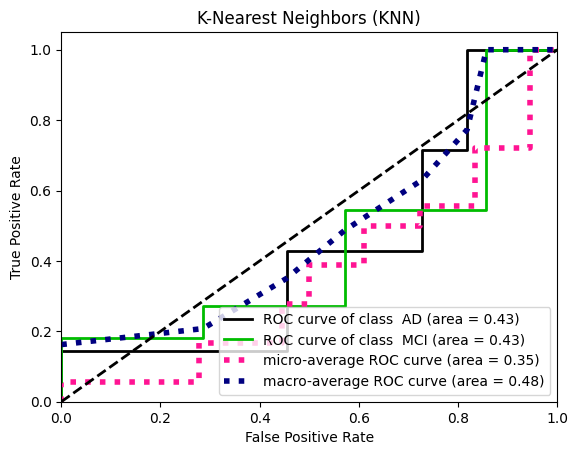

<Figure size 800x600 with 0 Axes>

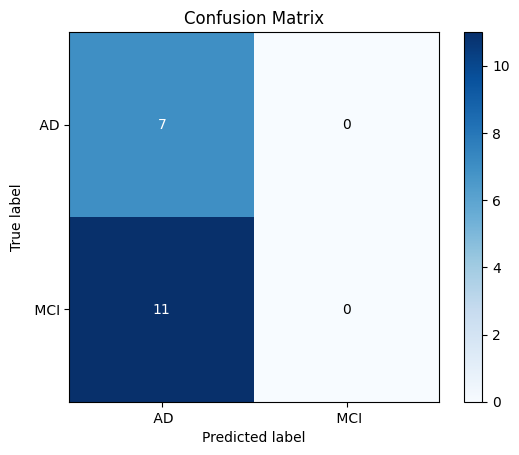

Test AUC: 0.4286
Test Accuracy: 0.3889


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import scikitplot.metrics

# Define train, validation, and test sets
[train_inds, test_inds] = next(model_selection.ShuffleSplit(test_size=0.2, random_state=100).split(MCIvAD, y=YMvA))
XTempTrain = MCIvAD[train_inds, :]

[train2_inds, val_inds] = next(model_selection.ShuffleSplit(test_size=0.4, random_state=100).split(XTempTrain, y=YMvA[train_inds]))
TrainInds = train_inds[train2_inds]
ValInds = train_inds[val_inds]
TestInds = test_inds

# Create sets of X and Y data using indices for MCIvAD
XTrainMvA = MCIvAD[TrainInds, :]
YTrainMvA = YMvA[TrainInds]
XValMvA = MCIvAD[ValInds, :]
YValMvA = YMvA[ValInds]
XTestMvA = MCIvAD[TestInds, :]
YTestMvA = YMvA[TestInds]

# Define the parameter grid for K-NN
grid = {
    'n_neighbors': range(1, 21),  # Number of neighbors
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric used
}

# Create KNN model
knn = KNeighborsClassifier()

# GridSearchCV for parameter tuning
paramGrid = GridSearchCV(estimator=knn, param_grid=grid, scoring='roc_auc', n_jobs=2, cv=5)
paramGrid.fit(XTrainMvA, YTrainMvA)

# Best parameters and model
bestModel = paramGrid.best_estimator_
print("Best parameters:", paramGrid.best_params_)
print("Best score:", paramGrid.best_score_)

# Predictions on Test Set
KNNTestPred = bestModel.predict_proba(XTestMvA)
KNNTestPred2 = bestModel.predict(XTestMvA)

# Plot ROC Curve and Confusion Matrix
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_roc(YTestMvA, KNNTestPred, title='K-Nearest Neighbors (KNN)')
plt.show()

plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_confusion_matrix(YTestMvA, KNNTestPred2)
plt.show()

# Metrics on test set
test_auc = roc_auc_score(YTestMvA, KNNTestPred[:, 1])
test_acc = accuracy_score(YTestMvA, KNNTestPred2)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


SVM

Best parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.5720833333333333


<Figure size 800x600 with 0 Axes>

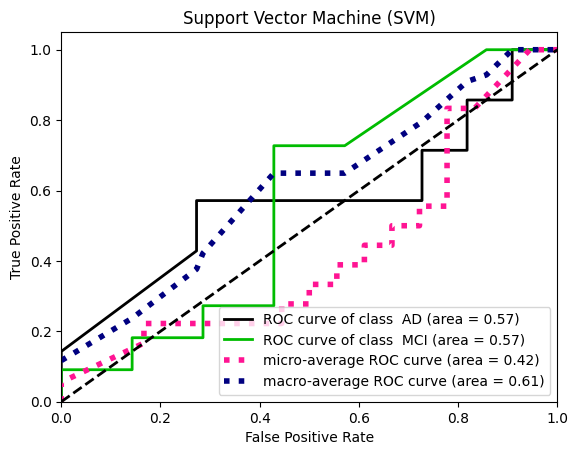

<Figure size 800x600 with 0 Axes>

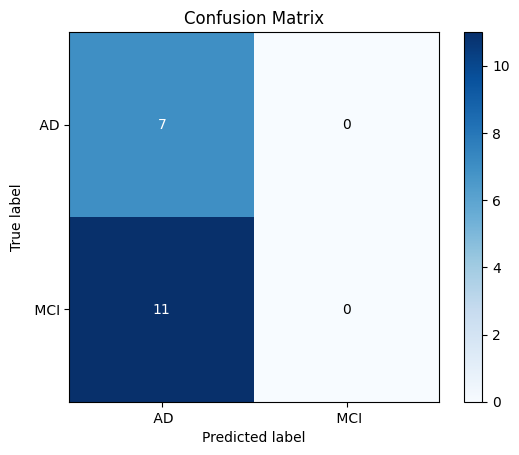

Test AUC: 0.5714
Test Accuracy: 0.3889


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import scikitplot.metrics

# Define train, validation, and test sets
[train_inds, test_inds] = next(model_selection.ShuffleSplit(test_size=0.2, random_state=100).split(MCIvAD, y=YMvA))
XTempTrain = MCIvAD[train_inds, :]

[train2_inds, val_inds] = next(model_selection.ShuffleSplit(test_size=0.4, random_state=100).split(XTempTrain, y=YMvA[train_inds]))
TrainInds = train_inds[train2_inds]
ValInds = train_inds[val_inds]
TestInds = test_inds

# Create sets of X and Y data using indices for MCIvAD
XTrainMvA = MCIvAD[TrainInds, :]
YTrainMvA = YMvA[TrainInds]
XValMvA = MCIvAD[ValInds, :]
YValMvA = YMvA[ValInds]
XTestMvA = MCIvAD[TestInds, :]
YTestMvA = YMvA[TestInds]

# Define the parameter grid for SVM
grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'gamma': [1, 0.1, 0.01, 0.001],  # Kernel coefficient for 'rbf'
    'kernel': ['rbf']  # Kernel type
}

# Create SVM model
svm = SVC(probability=True, random_state=100)

# GridSearchCV for parameter tuning
paramGrid = GridSearchCV(estimator=svm, param_grid=grid, scoring='roc_auc', n_jobs=2, cv=5)
paramGrid.fit(XTrainMvA, YTrainMvA)

# Best parameters and model
bestModel = paramGrid.best_estimator_
print("Best parameters:", paramGrid.best_params_)
print("Best score:", paramGrid.best_score_)

# Predictions on Test Set
SVMTestPred = bestModel.predict_proba(XTestMvA)
SVMTestPred2 = bestModel.predict(XTestMvA)

# Plot ROC Curve and Confusion Matrix
plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_roc(YTestMvA, SVMTestPred, title='Support Vector Machine (SVM)')
plt.show()

plt.figure(figsize=(8, 6))
scikitplot.metrics.plot_confusion_matrix(YTestMvA, SVMTestPred2)
plt.show()

# Metrics on test set
test_auc = roc_auc_score(YTestMvA, SVMTestPred[:, 1])
test_acc = accuracy_score(YTestMvA, SVMTestPred2)
print(f"Test AUC: {test_auc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


**III. AD vs HC**

In [ ]:
#All models for AD vs HC
# Set up Train, Val, Test sets for AD vs HC
[train_inds, test_inds] = next(
        model_selection.ShuffleSplit(
                test_size=0.2,random_state=100).split(
                        ADvHC,y=YAvH
                        )
        )

XTempTrain = MCIvAD[train_inds,]

# Split Train Set into Train and Validation Sets
[train2_inds, val_inds] = next(
        model_selection.ShuffleSplit(
                test_size=0.4,random_state=100).split(
                        XTempTrain,y=YAvH[train_inds]
                        )
        )

# Form the indices to select for each set
TrainInds = train_inds[train2_inds]
ValInds = train_inds[val_inds]
TestInds = test_inds

# Create sets of X and Y data using indices  for ADvHC

XTrainAvH = ADvHC[TrainInds,]
YTrainAvH = YAvH[TrainInds]
XValAvH = ADvHC[ValInds,]
YValAvH = YAvH[ValInds]
XTestAvH = ADvHC[TestInds,]
YTestAvH = YAvH[TestInds]

LRL

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Best model parameters: {'C': 1010.1010101011091, 'penalty': 'l2'}
Best model ROC AUC score: 0.7333


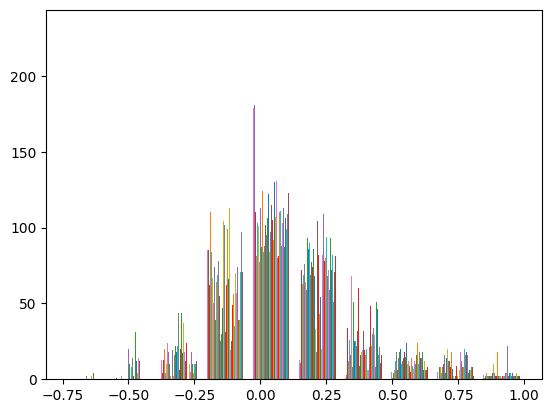

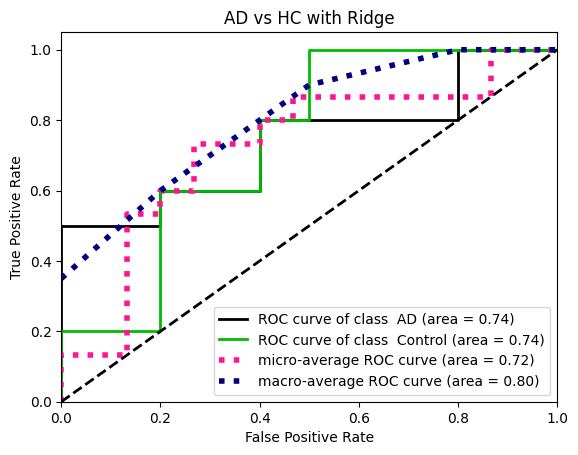

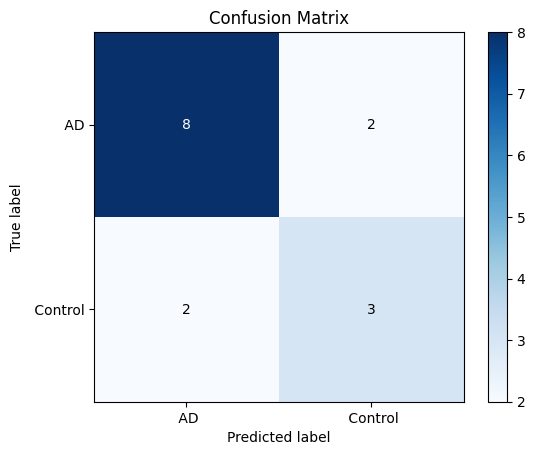

Logistic Regression Accuracy on Test Set: 73.3333%


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import scikitplot

# Assuming XTrainAvH, YTrainAvH, XValAvH, YValAvH, XTestAvH, YTestAvH are defined

# Testing for multicollinearity
coef3 = np.corrcoef(ADvHC, rowvar=False)
plt.hist(coef3)

# Split data into training, validation, and test sets
X_train, X_val, y_train, y_val = train_test_split(XTrainAvH, YTrainAvH, test_size=0.4, random_state=100)
X_test, y_test = XTestAvH, YTestAvH

# Parameter grid for Logistic Regression
grid = {
    'C': np.linspace(1e-10, 1e5, num=100),  # Inverse lambda
    'penalty': ['l2']  # Ridge regularization
}
# paramGrid = ParameterGrid(grid)  # No need to create a ParameterGrid object

# Logistic Regression model
RLRMod = LogisticRegression(tol=1e-10, random_state=100, n_jobs=2, verbose=1)

# Perform GridSearchCV, pass the 'grid' dictionary directly
grid_search = GridSearchCV(estimator=RLRMod, param_grid=grid,  # Use 'grid' instead of 'paramGrid'
                           scoring='roc_auc', n_jobs=2, verbose=1, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
bestModel = grid_search.best_estimator_
bestScore = grid_search.best_score_
allModels = grid_search.cv_results_['params']
allScores = grid_search.cv_results_['mean_test_score']

print(f"Best model parameters: {grid_search.best_params_}")
print(f"Best model ROC AUC score: {bestScore:.4f}")

# Predict probabilities and labels on the test set
RLRTestPred = bestModel.predict_proba(X_test)
RLRTestPred2 = bestModel.predict(X_test)

# Plot Receiver Operating Characteristic (ROC) Curve
scikitplot.metrics.plot_roc(y_test, RLRTestPred, title='AD vs HC with Ridge')
plt.show()

# Plot the Confusion Matrix for additional insight
scikitplot.metrics.plot_confusion_matrix(y_test, RLRTestPred2)
plt.show()

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, RLRTestPred2) * 100
print(f"Logistic Regression Accuracy on Test Set: {accuracy:.4f}%")

Random Forest

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Parameters found by RandomizedSearchCV:
{'n_estimators': 1200, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}



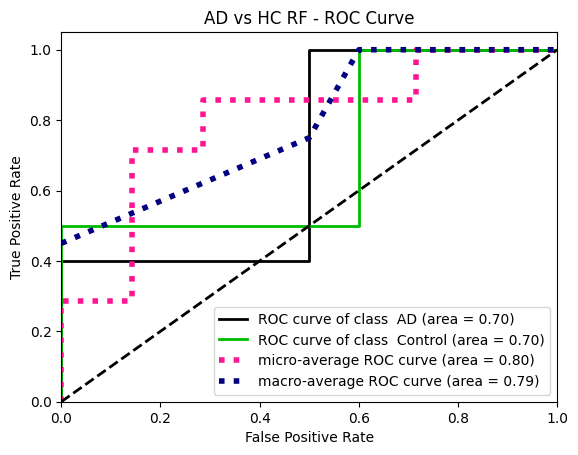

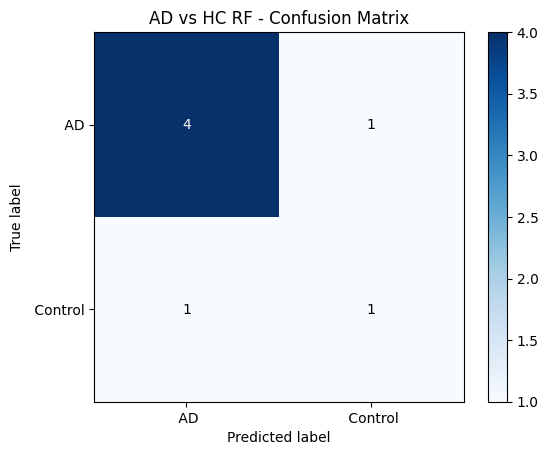

Random Forest Accuracy on Test Set: 0.7143


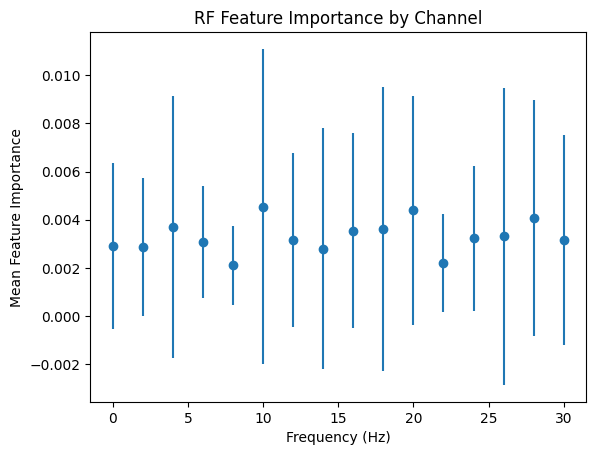

In [ ]:
# RF - AD vs HC without imblearn

# Import necessary libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score # Removed plot_roc_curve, plot_confusion_matrix
import scikitplot # scikitplot will be used instead for plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define the Hyperparameter grid values
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Split data into train and test sets (stratified sampling for class balance)
X_train, X_test, y_train, y_test = train_test_split(XTrainAvH, YTrainAvH, test_size=0.2, random_state=100, stratify=YTrainAvH)
# Use XTrainAvH and YTrainAvH since it appears you are building a model for AD vs HC

# Declare the Classifier
RFC = RandomForestClassifier(criterion='gini')  # can use 'entropy' instead

# RandomizedSearchCV for hyperparameter tuning
RFC_RandomSearch = RandomizedSearchCV(estimator=RFC,
                                      param_distributions=random_grid,
                                      n_iter=100, cv=3, verbose=2,
                                      random_state=10, n_jobs=2)
RFC_RandomSearch.fit(X_train, y_train)

# Look at the Tuned "Best" Parameters
print("Best Parameters found by RandomizedSearchCV:")
print(RFC_RandomSearch.best_params_)
print()

# Best estimator from RandomizedSearchCV
best_RFC = RFC_RandomSearch.best_estimator_

# Predictions on the test set
Pred1_S2 = best_RFC.predict(X_test)
Pred2_S2 = best_RFC.predict_proba(X_test)

# Plot ROC Curve and Confusion Matrix using scikitplot
scikitplot.metrics.plot_roc(y_test, Pred2_S2) # Use predict_proba output for ROC curve
plt.title('AD vs HC RF - ROC Curve')
plt.show()

scikitplot.metrics.plot_confusion_matrix(y_test, Pred1_S2) # Use predict output for confusion matrix
plt.title('AD vs HC RF - Confusion Matrix')
plt.show()

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, Pred1_S2)
print(f"Random Forest Accuracy on Test Set: {accuracy:.4f}")

# Feature Importance
FeatImp = best_RFC.feature_importances_

# Visualization of Feature Importance (if applicable to your dataset)
# Example of plotting feature importances by channel frequency
# Adjust this visualization according to your specific dataset
FeatImp_RF_MvA_reshape = np.reshape(FeatImp, [19, 16])
FeatImp_RF_mean = np.mean(FeatImp_RF_MvA_reshape, axis=0)
FeatImp_RF_std = np.std(FeatImp_RF_MvA_reshape, axis=0)
conf_int = stats.norm.interval(0.95, loc=FeatImp_RF_mean, scale=FeatImp_RF_std)

Freq_values = np.linspace(0, 30, 16)
plt.errorbar(Freq_values, FeatImp_RF_mean, yerr=FeatImp_RF_std, fmt='o')
plt.title("RF Feature Importance by Channel")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mean Feature Importance")
plt.show()


K-NN

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best Parameters found by GridSearchCV:
{'n_neighbors': 2, 'weights': 'uniform'}



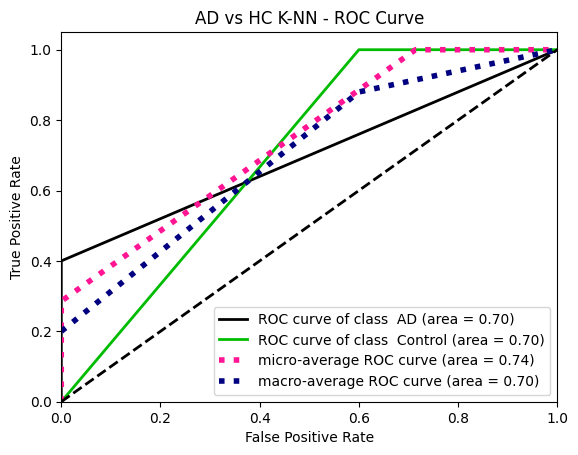

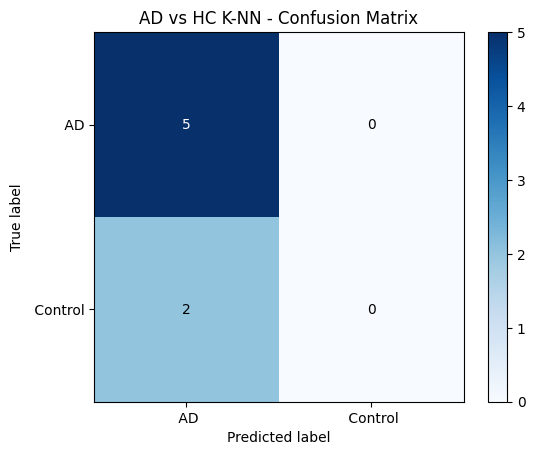

K-NN Accuracy on Test Set: 0.7143


In [ ]:
# K-NN - AD vs HC without imblearn

# Import necessary libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score # Removed plot_roc_curve, plot_confusion_matrix
import scikitplot # scikitplot will be used instead for plotting
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Assuming X and y are your feature and target data respectively.
# If you haven't defined them, replace them with the appropriate variables.
# For example, if your data is in XTrainAvH and YTrainAvH, use:
X = XTrainAvH
y = YTrainAvH

# Split data into train and test sets (stratified sampling for class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Define the Hyperparameters
n_neighbors = range(1, 21)  # Number of neighbors to consider
weights = ['uniform', 'distance']  # Weight function used in prediction

# Initialize the K-NN Classifier
knn = KNeighborsClassifier()

# Grid Search for Hyperparameter Tuning
param_grid = {'n_neighbors': n_neighbors, 'weights': weights}
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the Best Parameters found by GridSearchCV
print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print()

# Best estimator from GridSearchCV
best_knn = grid_search.best_estimator_

# Predictions on the test set
Pred1_S2 = best_knn.predict(X_test)
Pred2_S2 = best_knn.predict_proba(X_test)

# Plot ROC Curve and Confusion Matrix using scikitplot
scikitplot.metrics.plot_roc(y_test, Pred2_S2) # Use predict_proba output for ROC curve
plt.title('AD vs HC K-NN - ROC Curve')
plt.show()

scikitplot.metrics.plot_confusion_matrix(y_test, Pred1_S2) # Use predict output for confusion matrix
plt.title('AD vs HC K-NN - Confusion Matrix')
plt.show()
# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, Pred1_S2)
print(f"K-NN Accuracy on Test Set: {accuracy:.4f}")

# Note: Feature Importance is not applicable for K-NN, as it does not inherently provide feature importance scores.

SVM

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best Parameters found by GridSearchCV:
{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}



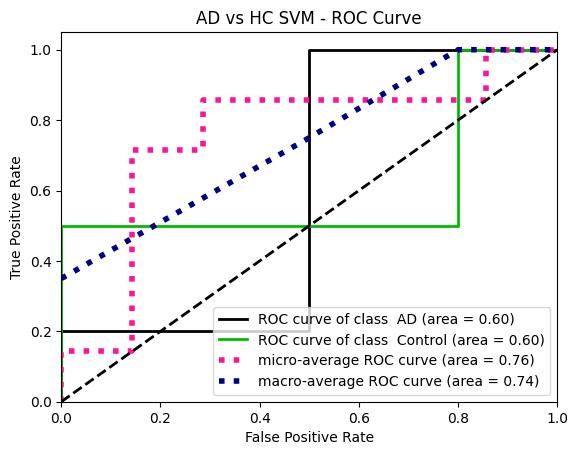

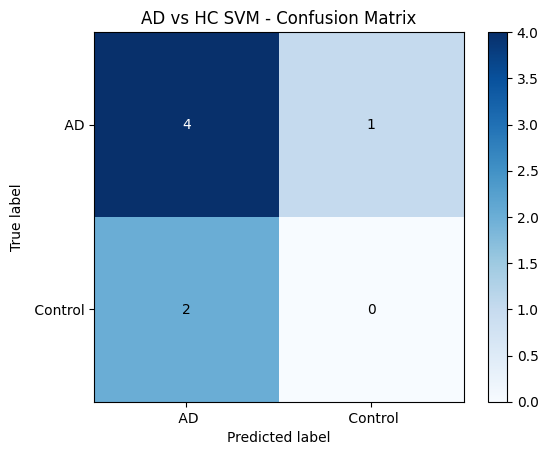

SVM Accuracy on Test Set: 0.5714


In [ ]:
# SVM - AD vs HC without imblearn

# Import necessary libraries
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score # Removed plot_roc_curve, plot_confusion_matrix
import scikitplot # scikitplot will be used instead for plotting
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Split data into train and test sets (stratified sampling for class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100, stratify=y)

# Define the Hyperparameters
param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}

# Initialize the SVM Classifier
svm = SVC(probability=True, random_state=100)

# Grid Search for Hyperparameter Tuning
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Print the Best Parameters found by GridSearchCV
print("Best Parameters found by GridSearchCV:")
print(grid_search.best_params_)
print()

# Best estimator from GridSearchCV
best_svm = grid_search.best_estimator_

# Predictions on the test set
Pred1_S2 = best_svm.predict(X_test)
Pred2_S2 = best_svm.predict_proba(X_test)

# Plot ROC Curve and Confusion Matrix using scikitplot
scikitplot.metrics.plot_roc(y_test, Pred2_S2) # Use predict_proba output for ROC curve
plt.title('AD vs HC SVM - ROC Curve')
plt.show()

scikitplot.metrics.plot_confusion_matrix(y_test, Pred1_S2) # Use predict output for confusion matrix
plt.title('AD vs HC SVM - Confusion Matrix')
plt.show()

# Calculate accuracy on the test set
accuracy = accuracy_score(y_test, Pred1_S2)
print(f"SVM Accuracy on Test Set: {accuracy:.4f}")